In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import os
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.utils import class_weight
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Dropout

# Import des librairies pour la gestion des Callback
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

In [4]:
EPOCHS                  = 100   # Nombre d'epoch
IMGSIZE                 = 250    # Taille des images
BATCH_SIZE              = 32    # Pour le traitement par lot des images (optimisation de la decente de gradient)
STOPPING_PATIENCE       = 10    # Callback pour stopper si le modèle n'apprend plus
VERBOSE                 = 1     # Niveau de verbosité
MODEL_NAME              = 'cnn_80epochs_imgsize160'
OPTIMIZER               = 'adam'
TRAIN_MODEL             = True  # Entrainement du modele (True) ou chargement (False)
UC_DIR_TRAIN = "/content/gdrive/MyDrive/ai4industry/n_train"
UC_DIR_TRAIN2 = "/content/gdrive/MyDrive/ai4industry/train_aug"

In [5]:
def check_Image(path):
    """ Permet d'ignorer les fichiers .ipynb_checkpoints"""
    if not ".ipynb_checkpoints" in path:
        return True
    else:
        return False

In [6]:
def gen_data(path):
    train_labels = []
    train_files = []
    for root, dirs, files in os.walk(path, topdown=False):
        if check_Image(root):
            for name in files:
                f = os.path.join(root, name)
                fs = f.split("/")
                #print("fs: ",fs)
                #si y'en a 5 alors c'est la classe good
                if len(f.split("/")) == 7:
                    train_labels.append(fs[6])
                    train_files.append(f)
                else:
                    train_labels.append(fs[6])
                    train_files.append(f)         
    df = pd.DataFrame({"img_path": train_files, "label": train_labels})
    return df

In [7]:
df_train1 = gen_data(UC_DIR_TRAIN)

df_train2 = gen_data(UC_DIR_TRAIN2)

In [8]:
df_train2.head()

,img_path,label
0,/content/gdrive/MyDrive/ai4industry/train_aug/...,EDGE_DEFECTS_ctrl
1,/content/gdrive/MyDrive/ai4industry/train_aug/...,EDGE_DEFECTS_ctrl
2,/content/gdrive/MyDrive/ai4industry/train_aug/...,EDGE_DEFECTS_ctrl
3,/content/gdrive/MyDrive/ai4industry/train_aug/...,EDGE_DEFECTS_ctrl
4,/content/gdrive/MyDrive/ai4industry/train_aug/...,EDGE_DEFECTS_ctrl


In [9]:
df_train1, df_val= train_test_split(df_train1, test_size=0.5, random_state=42)

In [10]:
df_train1.head()

,img_path,label
395,/content/gdrive/MyDrive/ai4industry/n_train/CH...,CHIPS_BROKEN_COATED_classI
680,/content/gdrive/MyDrive/ai4industry/n_train/Go...,Good
799,/content/gdrive/MyDrive/ai4industry/n_train/Go...,Good
968,/content/gdrive/MyDrive/ai4industry/n_train/CO...,COATING_DEFECTS_classI
688,/content/gdrive/MyDrive/ai4industry/n_train/Go...,Good


In [11]:
df_train = pd.concat([df_train1, df_train2])

In [12]:
len(df_train)

5874

In [13]:
def plot_hist(hist, metric="acc"):
    plt.plot(hist.history[metric])
    plt.plot(hist.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
train_datagen =  \
        ImageDataGenerator(
            rescale=1./255,
            validation_split=0.0)

In [15]:
train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            x_col='img_path',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

Found 5874 validated image filenames belonging to 16 classes.


In [16]:
valid_datagen =  \
        ImageDataGenerator(
            rescale=1./255,
            validation_split=0.0)

In [17]:
valid_generator = \
        valid_datagen.flow_from_dataframe(
            df_val,
            x_col='img_path',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

Found 504 validated image filenames belonging to 16 classes.


In [18]:
class_names = train_generator.class_indices
print(class_names)

{'CHIPS_BROKEN_COATED_classI': 0, 'CHIPS_BROKEN_COATED_classII': 1, 'CHIPS_BROKEN_COATED_ctrl': 2, 'CHIP_BROKEN_UNCOATED_classI': 3, 'CHIP_BROKEN_UNCOATED_classII': 4, 'CHIP_BROKEN_UNCOATED_ctrl': 5, 'COATING_DEFECTS_classI': 6, 'COATING_DEFECTS_classII': 7, 'COATING_DEFECTS_ctrl': 8, 'EDGE_DEFECTS_classI': 9, 'EDGE_DEFECTS_classII': 10, 'EDGE_DEFECTS_ctrl': 11, 'Good': 12, 'LOGO_DEFECTS_classI': 13, 'LOGO_DEFECTS_classII': 14, 'LOGO_DEFECTS_ctrl': 15}


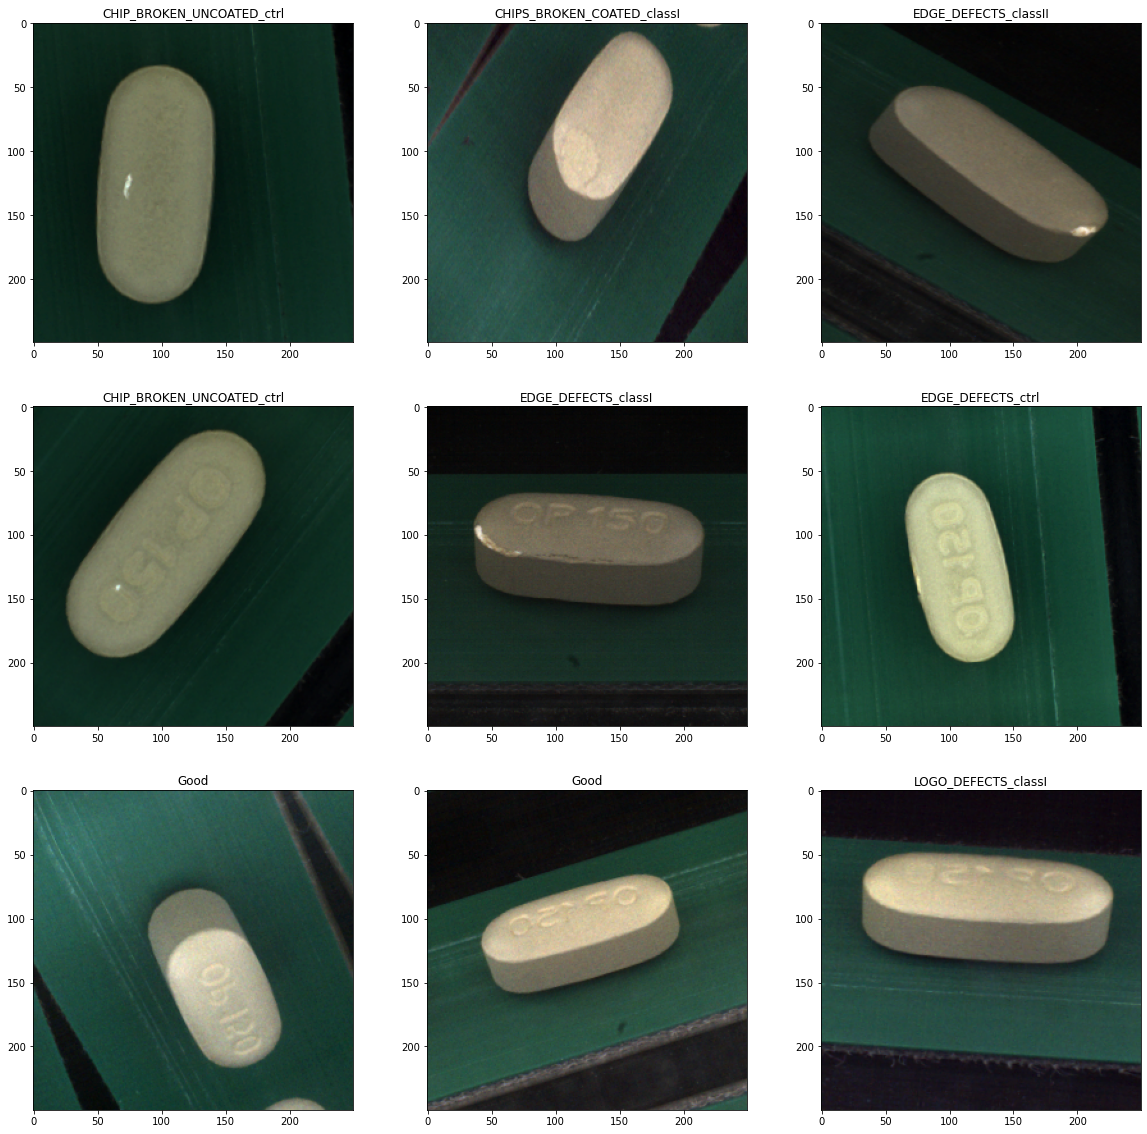

In [ ]:
# Get a batch of images and labels from the generator
images, labels = next(train_generator)

# Convert the labels tensor to a list of integers
labels = labels.argmax(1)

# Create a mapping from class index to class name
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Plot the first 9 images
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.ravel()

for i in range(9):
    axs[i].imshow(images[i])
    axs[i].set_title(class_labels[labels[i]])

plt.show()

In [ ]:
# Count the number of samples in each class
class_counts = np.unique(train_generator.classes, return_counts=True)[1]

# Print the percentage of samples that belong to each class
print("Training set class distribution:")
for i, count in enumerate(class_counts):
    print(f'Class {i}: {count/len(train_generator.classes):.2%} ({count})')
print(f"Total samples: {train_generator.samples}")

Training set class distribution:
Class 0: 6.11% (359)
Class 1: 6.03% (354)
Class 2: 5.99% (352)
Class 3: 5.96% (350)
Class 4: 6.09% (358)
Class 5: 4.63% (272)
Class 6: 6.13% (360)
Class 7: 6.09% (358)
Class 8: 5.99% (352)
Class 9: 6.09% (358)
Class 10: 6.06% (356)
Class 11: 6.08% (357)
Class 12: 10.44% (613)
Class 13: 6.13% (360)
Class 14: 6.11% (359)
Class 15: 6.06% (356)
Total samples: 5874


In [ ]:
##Définition d'un modele classique
#create model
OUTPUT = 16
model = Sequential()

#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(IMGSIZE, IMGSIZE, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D()),
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D()),
model.add(Flatten())
#model.add(Dropout(0.1))
model.add(Dense(OUTPUT, activation='softmax'))

In [ ]:
#compile model using accuracy to measure model performance
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
learningreduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=VERBOSE, factor=0.5, min_lr=0.00001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 248, 248, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      18464     
                                                                 
 batch_normalization_1 (Batc  (None, 122, 122, 32)     128       
 hNormalization)                                                 
                                                        

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_generator.classes), y=train_generator.classes)
# Convert to dictionary
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.0226323119777159,
 1: 1.0370762711864407,
 2: 1.04296875,
 3: 1.0489285714285714,
 4: 1.0254888268156424,
 5: 1.3497242647058822,
 6: 1.0197916666666667,
 7: 1.0254888268156424,
 8: 1.04296875,
 9: 1.0254888268156424,
 10: 1.03125,
 11: 1.028361344537815,
 12: 0.5988988580750407,
 13: 1.0197916666666667,
 14: 1.0226323119777159,
 15: 1.03125}

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[earlystop, learningreduction], validation_steps=valid_generator.n // BATCH_SIZE,steps_per_epoch=train_generator.n // BATCH_SIZE)

Epoch 1/100
183/183 [==============================] - 4668s 25s/step - loss: 32.1929 - accuracy: 0.1643 - val_loss: 37.9347 - val_accuracy: 0.0250 - lr: 0.0010
Epoch 2/100
183/183 [==============================] - 21s 112ms/step - loss: 22.4550 - accuracy: 0.2116 - val_loss: 30.1149 - val_accuracy: 0.0271 - lr: 0.0010
Epoch 3/100
183/183 [==============================] - 20s 111ms/step - loss: 14.4163 - accuracy: 0.2675 - val_loss: 13.3298 - val_accuracy: 0.0583 - lr: 0.0010
Epoch 4/100
183/183 [==============================] - 20s 110ms/step - loss: 7.4154 - accuracy: 0.3826 - val_loss: 10.3110 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 5/100
183/183 [==============================] - 21s 114ms/step - loss: 3.2952 - accuracy: 0.5443 - val_loss: 6.0967 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 6/100
183/183 [==============================] - 20s 110ms/step - loss: 1.3193 - accuracy: 0.7345 - val_loss: 5.5428 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 7/100
183/183 [==================

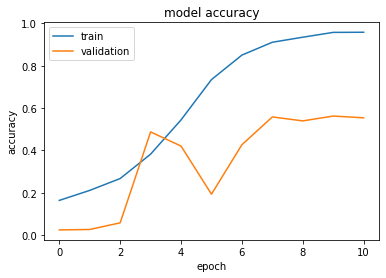

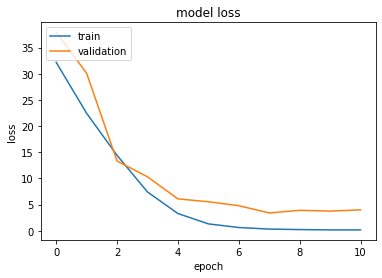

In [ ]:
plot_hist(history, "accuracy")
plot_hist(history, "loss")